In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
%matplotlib inline
from itertools import combinations
from itertools import chain
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools
from tools import mutant_colorset
from tools import condition_colorset

In [2]:
np.random.seed(953527608) # for exact figure reproducibility use this seed
# np.random.seed(None)

In [3]:
fitness_data = p.read_csv('../data/DoubleBC_Merged_Fitness_Atish_Default_AllConditions.csv')
fitness_data = p.read_csv('../data/fitnesses_merged_default_technical_timepoint.csv')



In [4]:
mutant_train_set = p.read_csv('../data/mutant_train_set.csv')
training_bcs = mutant_train_set['barcode'].values

In [5]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }


# m3_conditions = {**old_conditions,}
conditions = {**old_conditions, **bigbatch_conditions}
all_conditions = conditions.keys()
all_reps = [rep for reps in conditions.values() for rep in reps]

m3_conditions = list(old_conditions.keys()) + ['1BB_M3']
m3_reps = [rep for condition in m3_conditions for rep in conditions[condition]]


In [6]:
fitness_data

,barcode,gene,type,ploidy,class,additional_muts,13.1_error,13.1_fitness,13.2_error,13.2_fitness,...,Y_T3to4_error,Y_T3to4_fitness,Z_T0to1_error,Z_T0to1_fitness,Z_T1to2_error,Z_T1to2_fitness,Z_T2to3_error,Z_T2to3_fitness,Z_T3to4_error,Z_T3to4_fitness
0,53,Diploid,Diploid,Diploid,Diploid,TIP1-upstream_point_variant; YKR012C-upstream_...,0.086877,0.366047,0.083404,0.315150,...,0.110283,0.330491,0.135673,0.128220,0.174010,0.044473,0.237359,0.311749,0.254721,-0.428018
1,151,IRA1,stop_gained,Haploid,PKA,"MIM1,tS-upstream_indel_variant; SEH1-missense_...",0.059241,1.628226,0.059251,1.570717,...,0.100015,0.748416,0.100425,1.324769,0.100419,0.938699,0.100986,0.279141,0.100191,1.389472
2,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.069475,0.196277,0.068634,0.105044,...,0.118808,0.182910,0.141935,0.361742,0.240596,-0.626800,0.354750,0.254689,0.270718,0.345773
3,273,IRA1,frameshift_variant,Haploid,PKA,None,0.059303,1.133521,0.059304,1.206520,...,0.100108,0.633038,0.101534,1.058684,0.101313,1.081788,0.103650,0.103866,0.101319,0.770467
4,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.059382,1.113742,0.059383,1.101149,...,0.100486,0.333545,0.104328,1.076705,0.107939,0.300820,0.119433,0.189095,0.105068,1.152882
5,415,IRA1,frameshift_variant,Haploid,PKA,None,0.060026,1.328568,0.059880,1.330132,...,0.100050,0.409979,0.101415,1.439501,0.101085,1.192338,0.102232,0.411211,0.100950,0.602098
6,499,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.060481,1.198759,0.060173,1.177681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,622,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.167772,0.403564,0.238859,0.147452,...,0.116558,0.150748,0.173161,-0.355315,0.238136,0.076043,0.295350,0.635257,0.311012,-0.374773
8,689,IRA1,frameshift_variant,Haploid,PKA,RPL19A-upstream_point_variant,0.059639,1.351715,0.059628,1.287908,...,0.100122,0.575221,0.105185,1.370302,0.102800,1.552611,0.105243,0.499118,0.102353,0.556540
9,697,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.079211,0.292709,0.078981,0.195564,...,0.113712,0.209509,0.154005,-0.000688,0.194766,0.213834,0.386027,-0.466629,0.288405,0.382912


In [40]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

# fitness = this_data[[col+'_fitness' for col in all_conditions]].values
# error = this_data[[col+'_error' for col in all_conditions]].values

fitness = this_data[[col+'_fitness' for col in all_reps]].values
error = this_data[[col+'_error' for col in all_reps]].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

fitness_cols = np.asarray([col for col in all_reps])

m3_rep_indices = np.where(np.isin(fitness_cols,m3_reps))[0]
other_rep_indices = np.where(~np.isin(fitness_cols,m3_reps))[0]


# m3_rep_indices = np.where(np.isin(fitness_cols,['A','B','C','D']))[0]
# other_rep_indices = np.where(~np.isin(fitness_cols,['A','B','C','D']))[0]

In [41]:
this_data

,barcode,gene,type,ploidy,class,additional_muts,13.1_error,13.1_fitness,13.2_error,13.2_fitness,...,Y_T3to4_error,Y_T3to4_fitness,Z_T0to1_error,Z_T0to1_fitness,Z_T1to2_error,Z_T1to2_fitness,Z_T2to3_error,Z_T2to3_fitness,Z_T3to4_error,Z_T3to4_fitness
0,53,Diploid,Diploid,Diploid,Diploid,TIP1-upstream_point_variant; YKR012C-upstream_...,0.086877,0.366047,0.083404,0.315150,...,0.110283,0.330491,0.135673,0.128220,0.174010,0.044473,0.237359,0.311749,0.254721,-0.428018
1,151,IRA1,stop_gained,Haploid,PKA,"MIM1,tS-upstream_indel_variant; SEH1-missense_...",0.059241,1.628226,0.059251,1.570717,...,0.100015,0.748416,0.100425,1.324769,0.100419,0.938699,0.100986,0.279141,0.100191,1.389472
2,262,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.069475,0.196277,0.068634,0.105044,...,0.118808,0.182910,0.141935,0.361742,0.240596,-0.626800,0.354750,0.254689,0.270718,0.345773
3,273,IRA1,frameshift_variant,Haploid,PKA,None,0.059303,1.133521,0.059304,1.206520,...,0.100108,0.633038,0.101534,1.058684,0.101313,1.081788,0.103650,0.103866,0.101319,0.770467
4,323,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.059382,1.113742,0.059383,1.101149,...,0.100486,0.333545,0.104328,1.076705,0.107939,0.300820,0.119433,0.189095,0.105068,1.152882
5,415,IRA1,frameshift_variant,Haploid,PKA,None,0.060026,1.328568,0.059880,1.330132,...,0.100050,0.409979,0.101415,1.439501,0.101085,1.192338,0.102232,0.411211,0.100950,0.602098
8,689,IRA1,frameshift_variant,Haploid,PKA,RPL19A-upstream_point_variant,0.059639,1.351715,0.059628,1.287908,...,0.100122,0.575221,0.105185,1.370302,0.102800,1.552611,0.105243,0.499118,0.102353,0.556540
9,697,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.079211,0.292709,0.078981,0.195564,...,0.113712,0.209509,0.154005,-0.000688,0.194766,0.213834,0.386027,-0.466629,0.288405,0.382912
12,1379,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.059238,1.474213,0.059241,1.421350,...,0.100029,0.513007,0.100589,1.316493,0.100448,1.197686,0.101155,0.188134,0.100452,0.682905
13,1488,NotSequenced,NotSequenced,NotSequenced,NotSequenced,NotSequenced,0.059386,1.346518,0.059399,1.306377,...,0.100046,0.646774,0.101470,1.368132,0.100893,1.425734,0.102029,0.312370,0.100817,0.656618


2


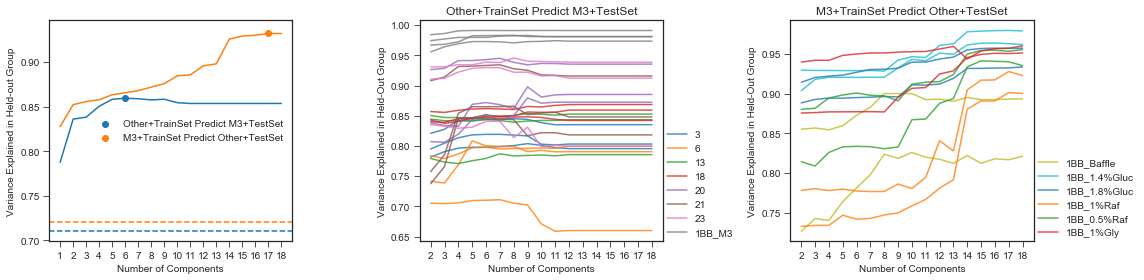

In [44]:
condition_colors = sns.color_palette()
condition_folds = [m3_rep_indices,other_rep_indices]
fold_names = ['Other+TrainSet Predict BigBatchM3+TrainSet','M3+TrainSet Predict Other+TestSet']
fold_names = ['Other+TrainSet Predict BigBatchM3+TestSet','BigBatchM3+TrainSet Predict Other+TestSet']
fold_names = ['Other+TrainSet Predict M3+TestSet','M3+TrainSet Predict Other+TestSet']
n_folds = 2 
mutant_permutation = np.random.permutation(n_mutants)

mutant_folds = [np.where(~np.isin(this_data['barcode'].values,training_bcs))[0],
                np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

# mutant_folds = [np.where(~np.isin(this_data['barcode'].values,training_bcs))[0],
#                 np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
                
# mutant_folds = [np.where(np.isin(this_data['barcode'].values,training_bcs))[0],
#                 np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

ax = plt.figure(figsize=(16,4))
folds = [(mutant_folds[i],condition_folds[i]) for i in range(2)]
print(len(folds))

all_fold, by_fold, by_condition, by_mutant, mean_fits = tools.SVD_predictions(fitness,folds,fitness.shape[0],fitness.shape[1],2)



plt.subplot(1,3,1)
max_rank = len(by_fold[0])
for fold in range(n_folds):
    this_fold = by_fold[fold]
    plt.plot(this_fold )
    plt.scatter(range(0,max_rank)[np.where(this_fold ==np.max(this_fold))[0][0]],np.max(this_fold),
                color=sns.color_palette()[fold],alpha=1.0,label=fold_names[fold])
    plt.axhline(mean_fits[fold],color=sns.color_palette()[fold],linestyle='--')
plt.xticks(np.arange(0,max_rank,1),np.arange(1,max_rank+1,1))
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained in Held-out Group')
# plt.ylim(0,1)

start = 1
for fold in range(n_folds):
    plt.subplot(1,3,fold+2)
    this_fold = by_condition[fold]

    this_fold = np.asarray(this_fold).swapaxes(0,1)
    max_rank = len(by_fold[0])
    already_plotted = []
    for k in range(this_fold.shape[0]):
        condition_name = [name for name, reps in conditions.items() for rep in reps if rep == fitness_cols[condition_folds[fold]][k]][0]
        index = np.where(np.asarray(list(conditions.keys()))==condition_name)[0][0]

        index =  index % len(condition_colors)
        if condition_name not in already_plotted:
            plt.plot(this_fold[k][start:],label=condition_name,color=condition_colors[index],alpha=0.8)
            already_plotted.append(condition_name)
        else:
            plt.plot(this_fold[k][start:],color=condition_colors[index],alpha=0.8)

    plt.xticks(np.arange(0,max_rank-start,1),np.arange(start+1,max_rank+1,1))
    plt.legend(loc=(1.0,0.0))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained in Held-Out Group')
    plt.title(fold_names[fold])
#     plt.ylim(0,1)
plt.tight_layout()
plt.savefig(f'prediction_trains_predict_tests_M3_noSalt_noconstraint.pdf',bbox_inches='tight')
# 


2


No handles with labels found to put in legend.
No handles with labels found to put in legend.


90
90
90
90
90


No handles with labels found to put in legend.


90
90
90
90
90
90


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


90
90
90
90
90
90


No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


90
228
228
228
228
228
228
228
228
228
228
228
228
228
228
228
228
228
228


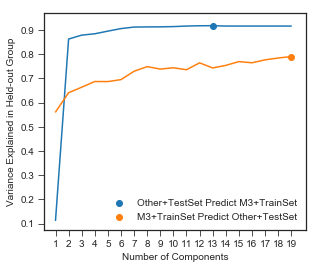

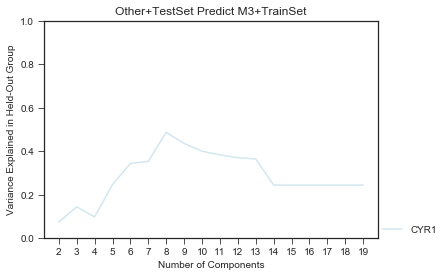

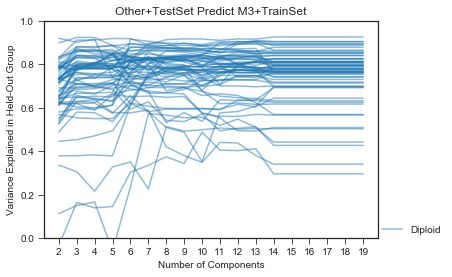

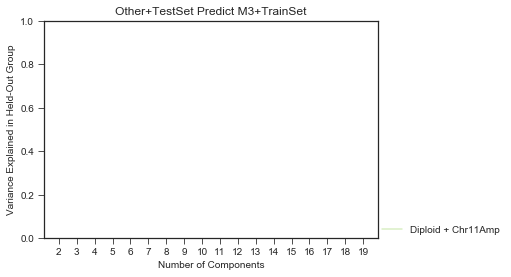

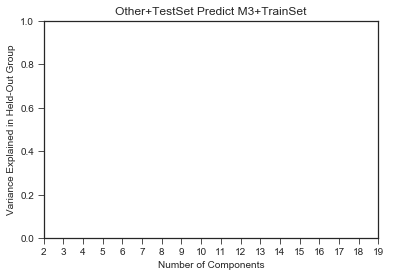

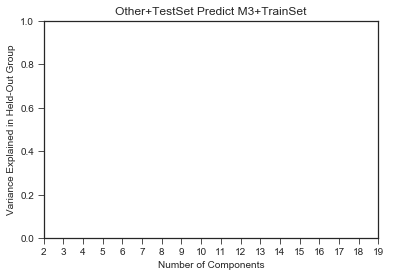

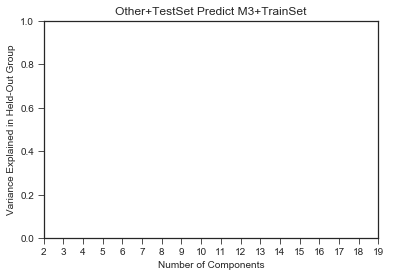

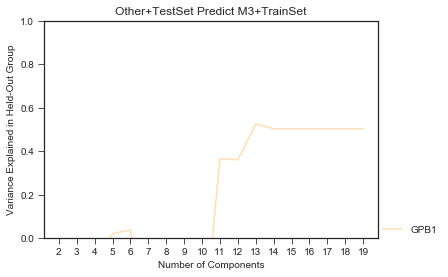

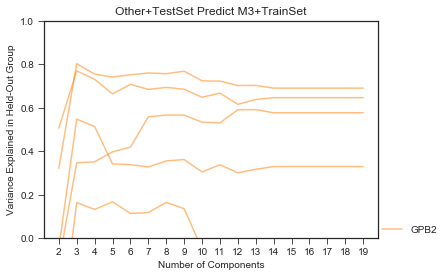

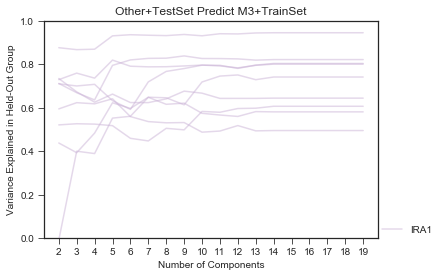

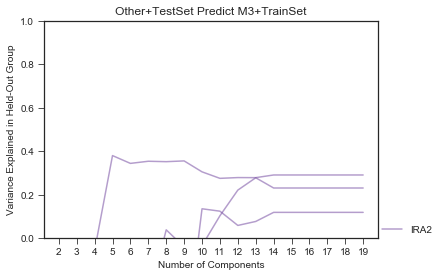

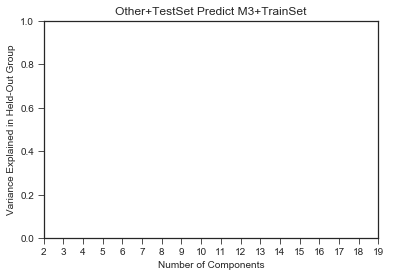

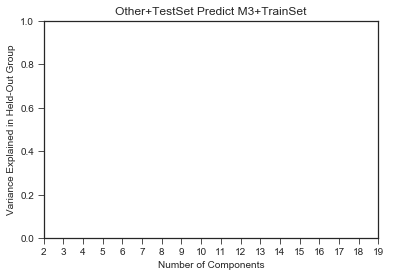

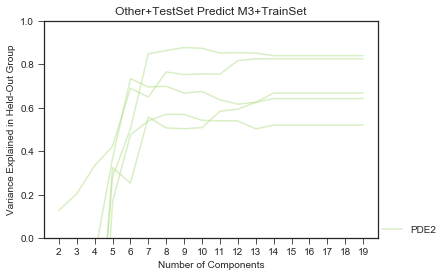

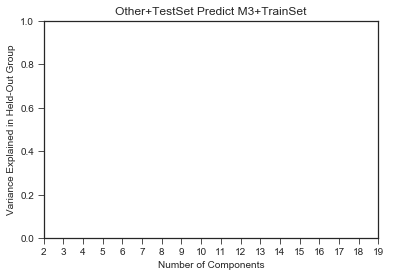

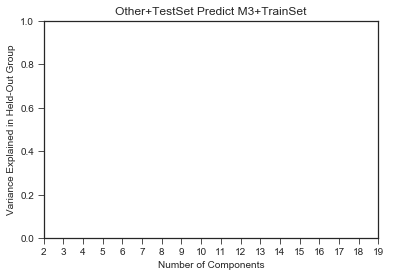

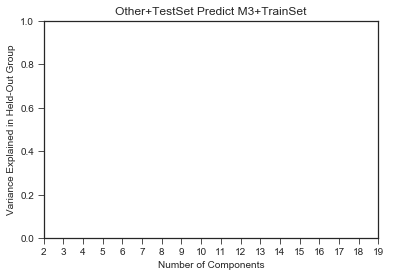

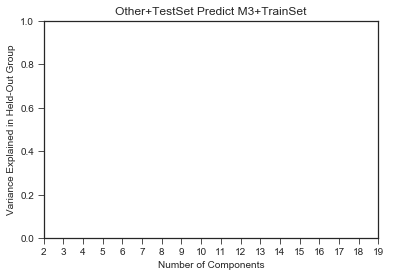

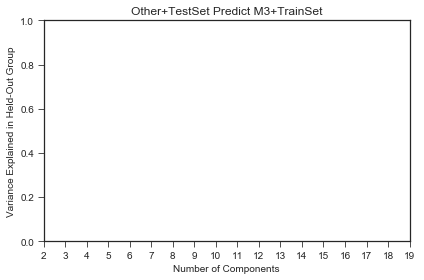

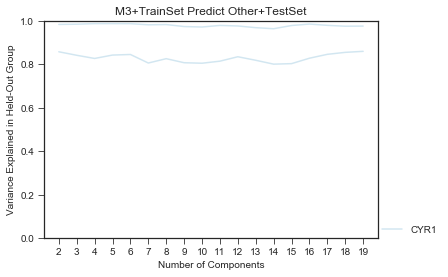

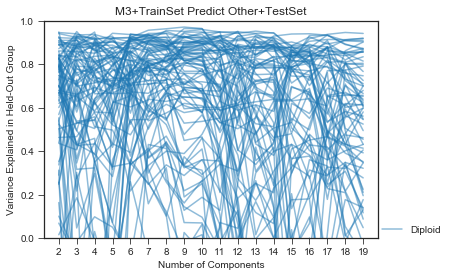

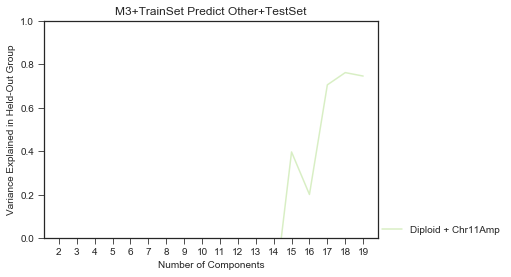

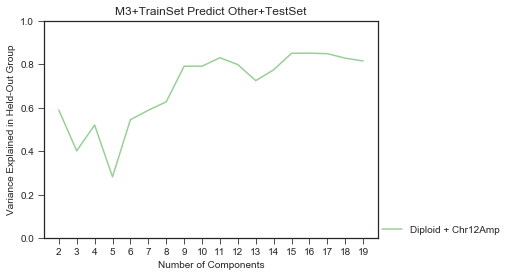

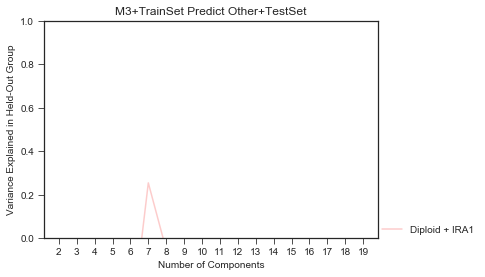

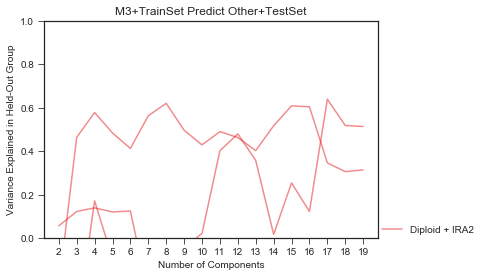

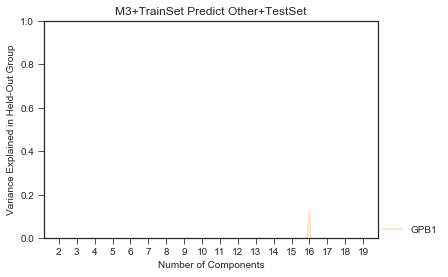

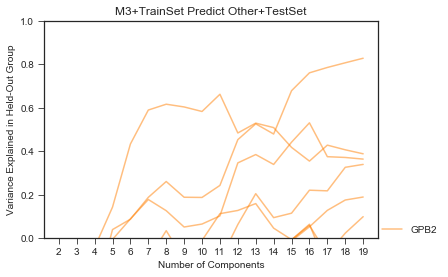

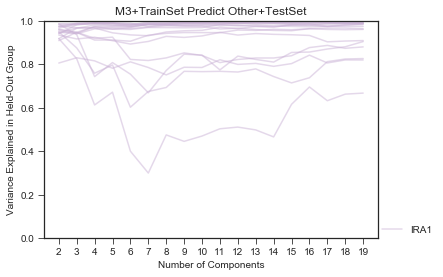

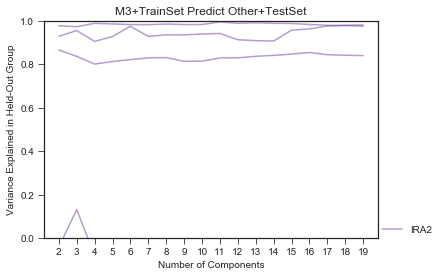

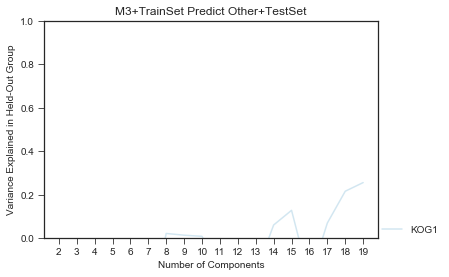

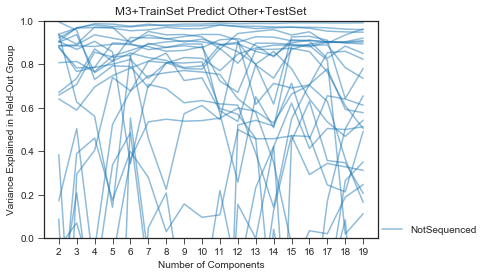

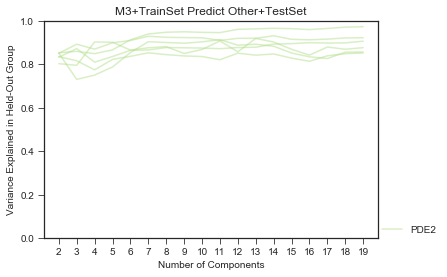

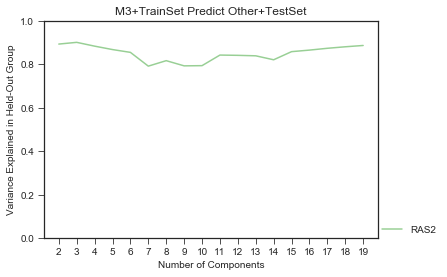

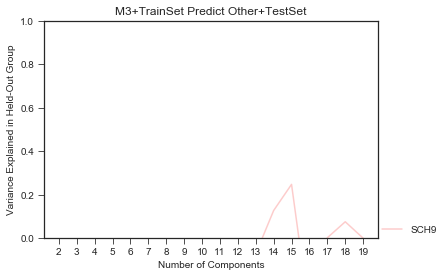

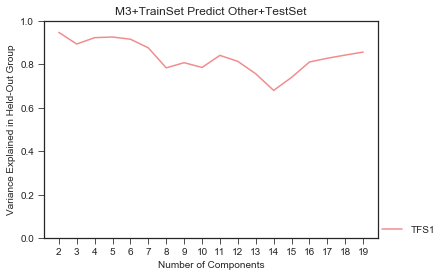

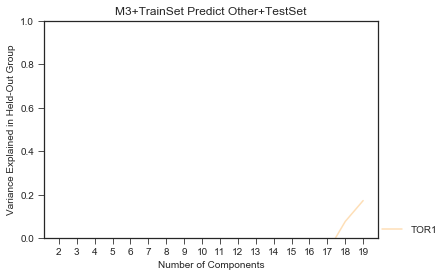

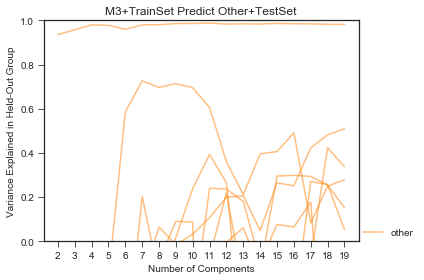

In [61]:
all_genes = np.unique(this_data['gene'].values)

mutant_colors = sns.color_palette("Paired",18)
# mutant_colors = {'NotSequenced':'k','other':'k',''}


condition_folds = [m3_rep_indices,other_rep_indices]
fold_names = ['Other+TestSet Predict M3+TrainSet','M3+TrainSet Predict Other+TestSet']
n_folds = 2 

# mutant_folds = [np.where(~np.isin(this_data['barcode'].values,training_bcs))[0],
#                 np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
                
mutant_folds = [np.where(np.isin(this_data['barcode'].values,training_bcs))[0],
                np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

ax = plt.figure(figsize=(16,4))
folds = [(mutant_folds[i],condition_folds[i]) for i in range(2)]
print(len(folds))

all_fold, by_fold, by_condition, by_mutant = tools.SVD_predictions(fitness,folds,fitness.shape[0],fitness.shape[1],2)



plt.subplot(1,3,1)
max_rank = len(by_fold[0])
for fold in range(n_folds):
    this_fold = by_fold[fold]
    plt.plot(this_fold )
    plt.scatter(range(0,max_rank)[np.where(this_fold ==np.max(this_fold))[0][0]],np.max(this_fold),
                color=sns.color_palette()[fold],alpha=1.0,label=fold_names[fold])

plt.xticks(np.arange(0,max_rank,1),np.arange(1,max_rank+1,1))
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained in Held-out Group')

start = 1
for fold in range(n_folds):
    for gene in all_genes:
#     plt.subplot(1,3,fold+2)
        plt.figure()
        this_fold = by_mutant[fold]

        this_fold = np.asarray(this_fold).swapaxes(0,1)
        max_rank = len(by_fold[0])
        already_plotted = []
        counter = 0
        for j in range(this_fold.shape[0]):
            counter +=1 
            mutant_index = mutant_folds[fold][j]
            this_gene = this_data['gene'].values[mutant_index]
            if this_gene == gene:

                index = np.where(np.asarray(list(all_genes))==this_gene)[0][0]

                index =  index % len(condition_colors)
                if this_gene not in already_plotted:
                    plt.plot(this_fold[j][start:],label=this_gene,color=mutant_colors[index],alpha=0.5)
                    already_plotted.append(this_gene)
                else:
                    plt.plot(this_fold[j][start:],color=mutant_colors[index],alpha=0.5)
        print(counter)
        plt.xticks(np.arange(0,max_rank-start,1),np.arange(start+1,max_rank+1,1))
        plt.legend(loc=(1.0,0.0))
        plt.xlabel('Number of Components')
        plt.ylabel('Variance Explained in Held-Out Group')
        plt.title(fold_names[fold])
        plt.ylim(0,1)
    plt.tight_layout()
# plt.savefig(f'prediction_.pdf',bbox_inches='tight')




In [121]:
### Just technical of M3_B predicting others
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

technical_reps = [col.split('_fitness')[0] for col in this_data if ('PCR' in col and '_fitness' in col ) ]

technical_b = [col for col in technical_reps if 'B.' in col]
technical_b = [
    'B.DE1.PCRa',
#  'B.DE1.PCRb',
#  'B.DE1.PCRc',
 'B.DE2.PCRa',
 'B.DE3.PCRa',
 'B.DE4.PCRa']

other_conditions =  {
                '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3'],
                        '1BB_M3':['A','B','C','D'],
#                         '1BB_Baffle':['E','F'],
#                         '1BB_1.4%Gluc' :['G','H'],
#                         '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
#                         '1BB_1%Raf' :['Y','Z'],
#                         '1BB_0.5%Raf' :['AA','BB'],
#                         '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }

other_reps = [rep for reps in other_conditions.values() for rep in reps]

these_reps = technical_b + other_reps

fitness = this_data[[col+'_fitness' for col in these_reps]].values
error = this_data[[col+'_error' for col in these_reps]].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

fitness_cols = np.asarray([col for col in these_reps])

techb_rep_indices = np.where(np.isin(fitness_cols,technical_b))[0]
other_rep_indices = np.where(~np.isin(fitness_cols,technical_b))[0]

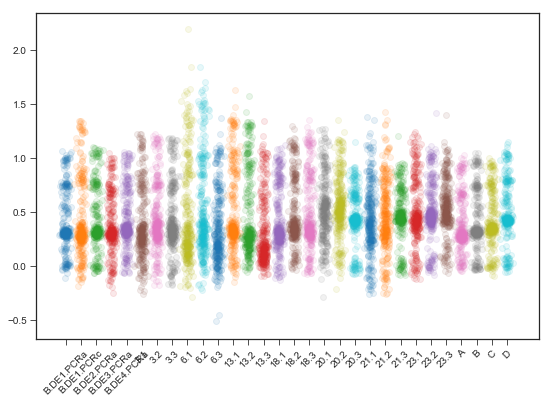

In [118]:
plt.figure(figsize=(9,6))
for x,col in enumerate(fitness_cols):
    plt.scatter([tools.jitter_point(x) for i in range(len(this_data[col+'_fitness'].values))],this_data[col+'_fitness'].values,alpha=0.1)
plt.xticks(range(len(fitness_cols)),fitness_cols,rotation=45)
plt.savefig('fitness+tech_M3_replicates.pdf',bbox_inches='tight')

2
3.1
3.2
3.3
6.1
6.2
6.3
13.1
13.2
13.3
18.1
18.2
18.3
20.1
20.2
20.3
21.1
21.2
21.3
23.1
23.2
23.3
A
B
C
D


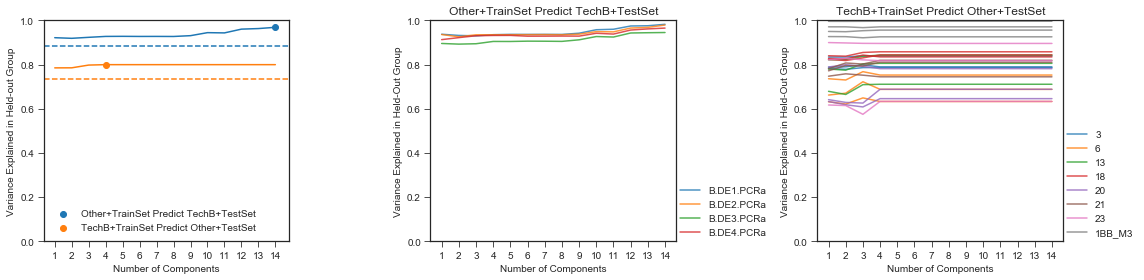

In [122]:
condition_colors = sns.color_palette()
condition_folds = [techb_rep_indices,other_rep_indices]
fold_names = ['Other+TrainSet Predict TechB+TestSet','TechB+TrainSet Predict Other+TestSet']
n_folds = 2 
mutant_permutation = np.random.permutation(n_mutants)

# mutant_folds = [np.where(~np.isin(this_data['barcode'].values,training_bcs))[0],
#                 np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
mutant_folds = [np.where(~np.isin(this_data['barcode'].values,training_bcs))[0],
                np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]
                
# mutant_folds = [np.where(np.isin(this_data['barcode'].values,training_bcs))[0],
#                 np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

ax = plt.figure(figsize=(16,4))
folds = [(mutant_folds[i],condition_folds[i]) for i in range(2)]
print(len(folds))

all_fold, by_fold, by_condition, by_mutant, mean_fits = tools.SVD_predictions(fitness,folds,fitness.shape[0],fitness.shape[1],2)



plt.subplot(1,3,1)
max_rank = len(by_fold[0])
for fold in range(n_folds):
    this_fold = by_fold[fold]
    plt.plot(this_fold )
    plt.scatter(range(0,max_rank)[np.where(this_fold ==np.max(this_fold))[0][0]],np.max(this_fold),
                color=sns.color_palette()[fold],alpha=1.0,label=fold_names[fold])
    plt.axhline(mean_fits[fold],color=sns.color_palette()[fold],linestyle='--')

plt.xticks(np.arange(0,max_rank,1),np.arange(1,max_rank+1,1))
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained in Held-out Group')
plt.ylim(0,1.0)

start = 0
for fold in range(n_folds):
    plt.subplot(1,3,fold+2)
    this_fold = by_condition[fold]

    this_fold = np.asarray(this_fold).swapaxes(0,1)
    max_rank = len(by_fold[0])
    already_plotted = []
    for k in range(this_fold.shape[0]):
        if 'PCR' not in fitness_cols[condition_folds[fold]][k]:
            print(fitness_cols[condition_folds[fold]][k])
            condition_name = [name for name, reps in other_conditions.items() for rep in reps if rep == fitness_cols[condition_folds[fold]][k]][0]
            index = np.where(np.asarray(list(other_conditions.keys()))==condition_name)[0][0]
        else:
#             print(techincal)
            condition_name = fitness_cols[condition_folds[fold]][k]
            index = np.where(np.asarray(technical_b)==condition_name)[0][0]

        index =  index % len(condition_colors)
        if condition_name not in already_plotted:
            plt.plot(this_fold[k][start:],label=condition_name,color=condition_colors[index],alpha=0.8)
            already_plotted.append(condition_name)
        else:
            plt.plot(this_fold[k][start:],color=condition_colors[index],alpha=0.8)
        

    plt.xticks(np.arange(0,max_rank-start,1),np.arange(start+1,max_rank+1,1))
    plt.legend(loc=(1.0,0.0))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained in Held-Out Group')
    plt.title(fold_names[fold])
    plt.ylim(0,1.0)
plt.tight_layout()
plt.savefig(f'prediction_TechB-NoDE1bc_M3_constraint.pdf',bbox_inches='tight')




In [140]:
### Just technical of M3_B predicting others
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

technical_reps = [col.split('_fitness')[0] for col in this_data if ('PCR' in col and '_fitness' in col ) ]

technical_b = [col for col in technical_reps if 'B.' in col]
technical_b = ['B.DE1.PCRa',
#  'B.DE1.PCRb',
 'B.DE1.PCRc',
 'B.DE2.PCRa',
 'B.DE3.PCRa',
 'B.DE4.PCRa']

old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

old_reps = [rep for reps in old_conditions.values() for rep in reps]

oldother_conditions = {**old_conditions, **bigbatch_conditions}

these_reps = technical_b + old_reps 

fitness = this_data[[col+'_fitness' for col in these_reps]].values
error = this_data[[col+'_error' for col in these_reps]].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

fitness_cols = np.asarray([col for col in these_reps])

techb_rep_indices = np.where(np.isin(fitness_cols,technical_b))[0]
other_rep_indices = np.where(~np.isin(fitness_cols,technical_b))[0]

2
3.1
3.2
3.3
6.1
6.2
6.3
13.1
13.2
13.3
18.1
18.2
18.3
20.1
20.2
20.3
21.1
21.2
21.3
23.1
23.2
23.3


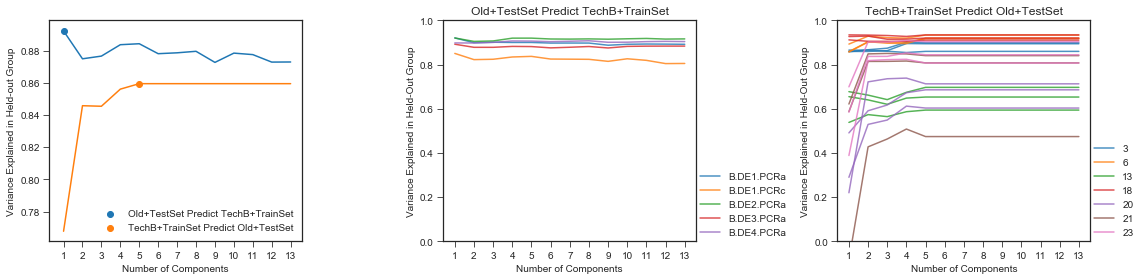

In [143]:
condition_colors = sns.color_palette("Paired",len(old_conditions.keys()))
condition_colors = sns.color_palette()
condition_folds = [techb_rep_indices,other_rep_indices]
fold_names = ['Old+TestSet Predict TechB+TrainSet','TechB+TrainSet Predict Old+TestSet']
n_folds = 2 
mutant_permutation = np.random.permutation(n_mutants)

mutant_folds = [np.where(~np.isin(this_data['barcode'].values,training_bcs))[0],
                np.where(np.isin(this_data['barcode'].values,training_bcs))[0]]
                
# mutant_folds = [np.where(np.isin(this_data['barcode'].values,training_bcs))[0],
#                 np.where(~np.isin(this_data['barcode'].values,training_bcs))[0]]

ax = plt.figure(figsize=(16,4))
folds = [(mutant_folds[i],condition_folds[i]) for i in range(2)]
print(len(folds))

all_fold, by_fold, by_condition, by_mutant = tools.SVD_predictions(fitness,folds,fitness.shape[0],fitness.shape[1],2)



plt.subplot(1,3,1)
max_rank = len(by_fold[0])
for fold in range(n_folds):
    this_fold = by_fold[fold]
    plt.plot(this_fold )
    plt.scatter(range(0,max_rank)[np.where(this_fold ==np.max(this_fold))[0][0]],np.max(this_fold),
                color=sns.color_palette()[fold],alpha=1.0,label=fold_names[fold])

plt.xticks(np.arange(0,max_rank,1),np.arange(1,max_rank+1,1))
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained in Held-out Group')

start = 0
for fold in range(n_folds):
    plt.subplot(1,3,fold+2)
    this_fold = by_condition[fold]

    this_fold = np.asarray(this_fold).swapaxes(0,1)
    max_rank = len(by_fold[0])
    already_plotted = []
    for k in range(this_fold.shape[0]):
        if 'PCR' not in fitness_cols[condition_folds[fold]][k]:
            print(fitness_cols[condition_folds[fold]][k])
            condition_name = [name for name, reps in old_conditions.items() for rep in reps if rep == fitness_cols[condition_folds[fold]][k]][0]
            index = np.where(np.asarray(list(old_conditions.keys()))==condition_name)[0][0]
        else:
#             print(techincal)
            condition_name = fitness_cols[condition_folds[fold]][k]
            index = np.where(np.asarray(technical_b)==condition_name)[0][0]

        index =  index % len(condition_colors)
        if condition_name not in already_plotted:
            plt.plot(this_fold[k][start:],label=condition_name,color=condition_colors[index],alpha=0.8)
            already_plotted.append(condition_name)
        else:
            plt.plot(this_fold[k][start:],color=condition_colors[index],alpha=0.8)

    plt.xticks(np.arange(0,max_rank-start,1),np.arange(start+1,max_rank+1,1))
    plt.legend(loc=(1.0,0.0))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance Explained in Held-Out Group')
    plt.title(fold_names[fold])
    plt.ylim(0,1)
plt.tight_layout()
plt.savefig(f'prediction_TechB-NoDE1b_Old_constraint.pdf',bbox_inches='tight')





In [111]:
condition_colors

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313)]

In [69]:
reg = LinearRegression(fit_intercept=False).fit(U[:,:s2.shape[0]],m3_fitness)

In [108]:
U[:,:1]

array([[-0.04406576],
       [-0.13804843],
       [-0.10624164],
       [-0.10108575],
       [-0.12940898],
       [-0.12862571],
       [-0.03867174],
       [-0.13372619],
       [-0.12830989],
       [-0.09141758],
       [-0.08696874],
       [-0.07476816],
       [-0.09560612],
       [-0.09352957],
       [-0.06265431],
       [-0.0991295 ],
       [-0.04026535],
       [-0.02858561],
       [-0.10335268],
       [-0.13683148],
       [-0.03912104],
       [-0.06809763],
       [-0.10970742],
       [-0.09996001],
       [-0.08372738],
       [-0.08615105],
       [-0.08021332],
       [-0.07955005],
       [-0.04208377],
       [-0.09685596],
       [-0.09605316],
       [-0.12680487],
       [-0.09767383],
       [-0.12080033],
       [-0.08111262],
       [-0.08496567],
       [-0.00044986],
       [-0.1270467 ],
       [-0.09627287],
       [-0.09707233],
       [-0.09575789],
       [-0.114736  ],
       [-0.12416293],
       [-0.09765033],
       [-0.12378479],
       [-0

71
0.05941103238366035 0.007107102339336403 0.1196259693560055


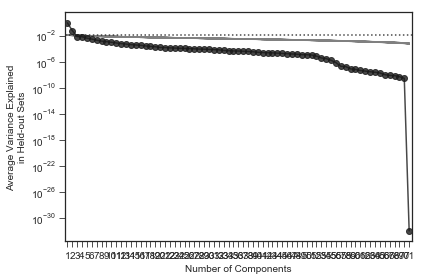

In [83]:
### PLOT SVD FROM ALL CONDITIONS!!

this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

fitness = this_data[[col for col in this_data.columns if 'fitness' in col]].values
error =  this_data[[col for col in this_data.columns if 'error' in col]].values

fitness_cols = []
for col in [column for column in this_data.columns if 'fitness' in column]:
    if '_T' not in col:
        if 'SV' not in col:
            fitness_cols.append(col)
            
fitness_cols = [col for col in fitness_cols if col not in ['B.DE1.PCRb_fitness','1BB_0.5MKCl_fitness','P_fitness']]

print(len(fitness_cols))
fitness = this_data[[col for col in fitness_cols]].values
# fitness = (fitness - np.mean(fitness))/np.std(fitness)
error =  this_data[[col.replace('fitness','error') for col in fitness_cols]].values

# n_folds = 5
# folds = tools.make_folds(fitness.shape[0],fitness.shape[1],n_folds)
ax = plt.figure()
tools.svd_noise_comparison_figure(ax,fitness,error,100)

plt.ylabel('Average Variance Explained\nin Held-out Sets')
plt.xlabel('Number of Components')
plt.yscale('log')

plt.tight_layout()


In [215]:
mutant_colorset = {'CYR1':'#cab2d6', # light purple
                 'Diploid':'#fb9a99', # light red
                 'Diploid + Chr11Amp':'#e31a1c', # dark red
                 'Diploid + Chr12Amp':'#e31a1c',
                 'Diploid + IRA1':'#e31a1c',
                 'Diploid + IRA2':'#e31a1c',
                 'GPB1':'#b2df8a',  # light green
                 'GPB2':'#33a02c',  # dark green
                 'IRA1':'#1f78b4', # dark blue
                 'IRA2':'#a6cee3', # light blue
                 'KOG1':'#6a3d9a', # dark purple
                 'NotSequenced':'gray',
                 'PDE2':'#ff7f00',  # dark orange
                 'RAS2':'#ffff99',
                 'SCH9':'#6a3d9a', # dark purple
                 'TFS1':'#6a3d9a',# dark purple
                 'TOR1':'#6a3d9a',# dark purple
                 'other':'THIS IS NOT A COLOR'}


# condition_colorset = 


In [330]:
fitness

array([[-0.30936608, -0.42992997, -0.86528747, ..., -0.09565987,
         0.00737828, -0.01157479],
       [-0.66919147, -0.6353557 , -1.02456557, ...,  2.0447396 ,
         2.54868807,  2.25546213],
       [-0.9493169 , -1.20719905, -1.06360775, ...,  0.04217877,
         0.1016703 , -0.09788649],
       ...,
       [-0.29852464, -0.73437903, -0.93000839, ..., -0.0432394 ,
         0.06395969, -0.02559764],
       [-0.0817825 , -0.34616673, -0.32025446, ..., -0.13498611,
        -0.10832693,  0.02145932],
       [-1.31444739, -1.29784995, -1.07249514, ..., -1.35127081,
        -1.34858663, -1.15599239]])

In [108]:
old_conditions = {
                  '3':['3.1','3.2','3.3'],
                  '6':['6.1','6.2','6.3'],
                  '13':['13.1','13.2','13.3'],
                  '18':['18.1','18.2','18.3'],
                  '20':['20.1','20.2','20.3'],
                  '21':['21.1','21.2','21.3'],
                  '23':['23.1','23.2','23.3']
                 }

bigbatch_conditions = {
                        '1BB_M3':['A','B','C','D'],
                        '1BB_Baffle':['E','F'],
                        '1BB_1.4%Gluc' :['G','H'],
                        '1BB_1.8%Gluc' :['I','J'],
#                         '1BB_0.2MNaCl' :['K','L'],
#                         '1BB_0.2MKCl' :['O'],
#                         '1BB_0.5MKCl' :['P'],
#                         '1BB_8.5uMGdA' :['Q','R'],
#                         '1BB_17uMGdA' :['S','T'],
#                         '1BB_2ugFlu' :['U','V'],
#                         '1BB_0.5ugFlu' :['W','X'],
                        '1BB_1%Raf' :['Y','Z'],
                        '1BB_0.5%Raf' :['AA','BB'],
                        '1BB_1%Gly' :['CC','DD'],
#                         '1BB_1%EtOH' :['EE','FF'],
#                         '1BB_SucRaf' :['GG'],
                      }

all_conditions = {**old_conditions,**bigbatch_conditions}
conditions = {**old_conditions,**bigbatch_conditions}

just_reps = [rep for reps in all_conditions.values() for rep in reps]

In [109]:
just_reps

['3.1',
 '3.2',
 '3.3',
 '6.1',
 '6.2',
 '6.3',
 '13.1',
 '13.2',
 '13.3',
 '18.1',
 '18.2',
 '18.3',
 '20.1',
 '20.2',
 '20.3',
 '21.1',
 '21.2',
 '21.3',
 '23.1',
 '23.2',
 '23.3',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'Y',
 'Z',
 'AA',
 'BB',
 'CC',
 'DD']

In [73]:
[name for name, reps in all_conditions.items() for rep in just_reps if rep == rep_name]

[]

In [104]:
condition_colorset

condition_colorset

{'13': (0.9921568627450981, 0.7529411764705882, 0.5254901960784314),
 '18': (1.0, 1.0, 0.6),
 '1BB_0.2MKCl': (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 '1BB_0.2MNaCl': (0.984313725490196, 0.6039215686274509, 0.6),
 '1BB_0.5%Raf': (1.0, 0.4980392156862745, 0.0),
 '1BB_0.5MKCl': (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 '1BB_1%Gly': (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 '1BB_1%Raf': (1.0, 1.0, 1.0),
 '1BB_1.4%Gluc': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 '1BB_1.8%Gluc': (0.2, 0.6274509803921569, 0.17254901960784313),
 '1BB_Baffle': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 '1BB_M3': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 '20': (0.2196078431372549, 0.4235294117647059, 0.6901960784313725),
 '21': (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 '23': (0.7490196078431373, 0.3568627450980392, 0.09019607843137253),
 '3': (0.4980392156862745, 

In [101]:
condition_name

'1BB_l%Raf'

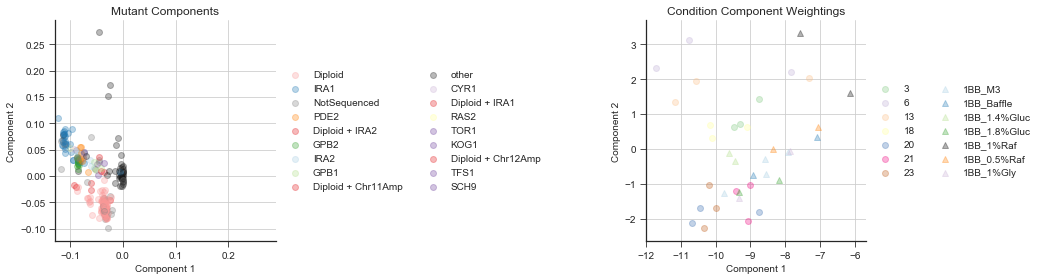

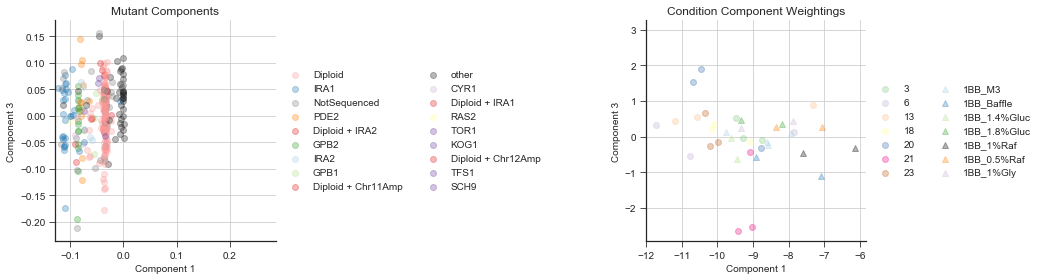

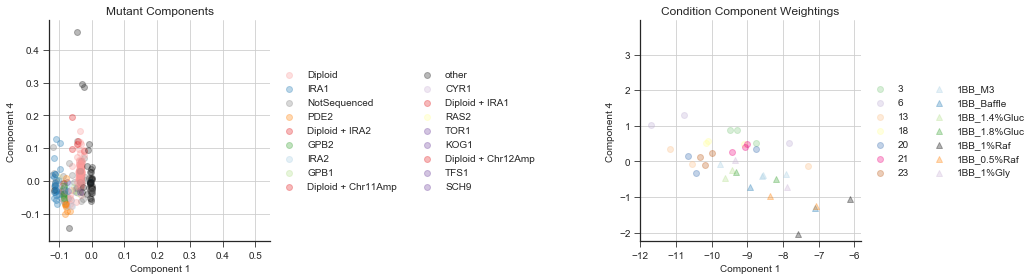

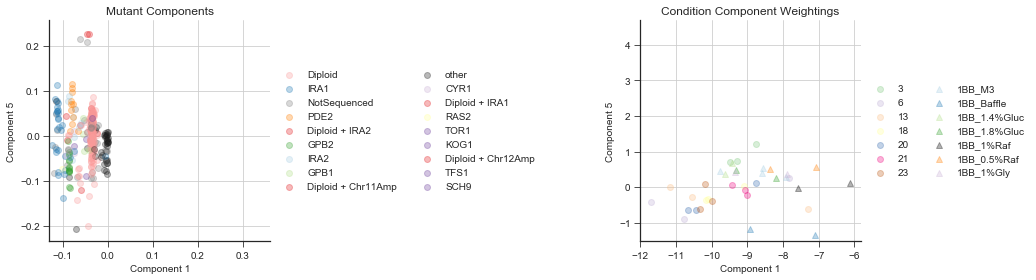

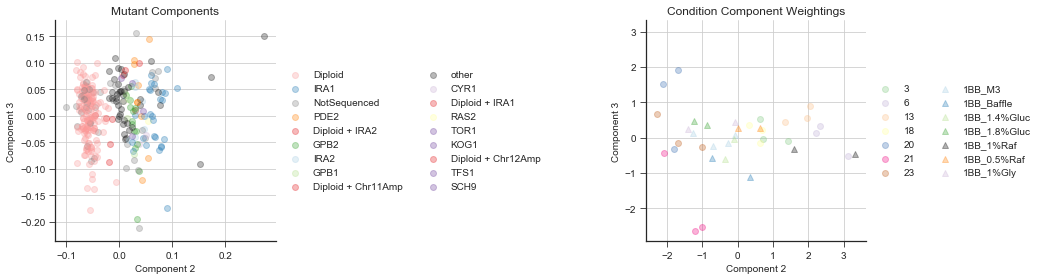

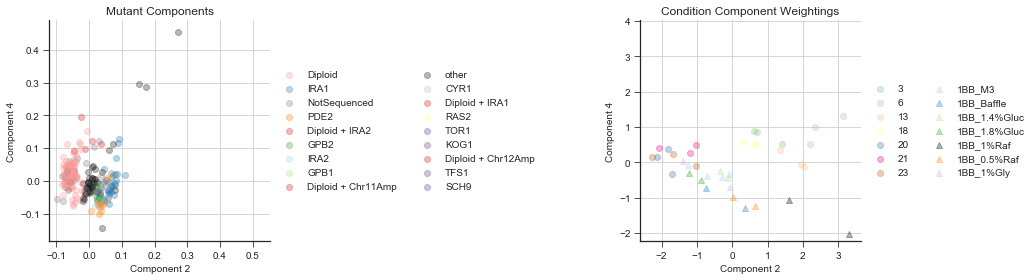

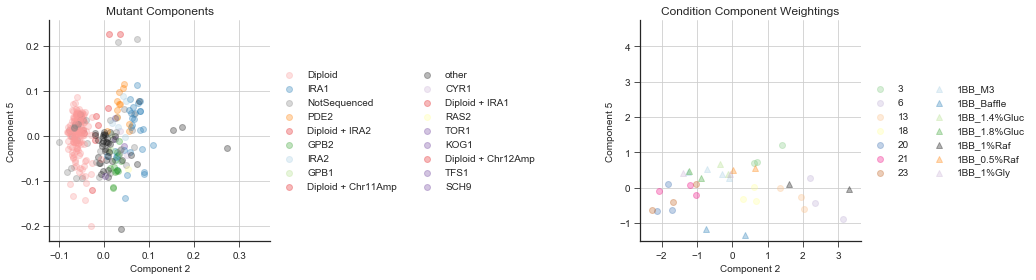

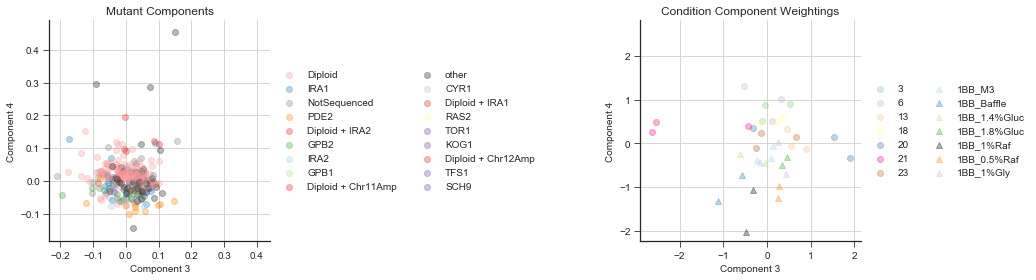

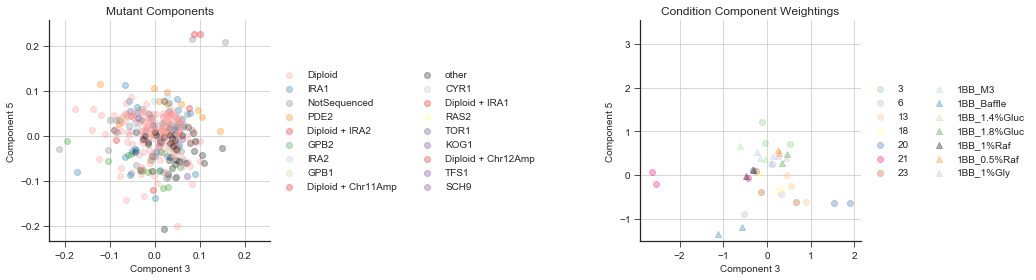

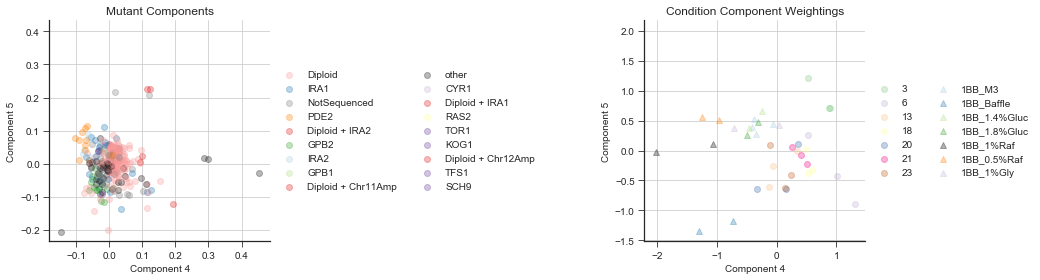

In [110]:
# fitness = (fitness - np.mean(fitness))/np.std(fitness)
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

# fitness_cols = [col for col in fitness_cols if col not in ['B.DE1.PCRb_fitness','1BB_0.5MKCl_fitness','P_fitness']]

# print(len(fitness_cols))
fitness_cols = [col+'_fitness' for col in just_reps]
fitness = this_data[fitness_cols].values

U, s, V = np.linalg.svd(fitness)

# color_set = sns.color_palette("Paired",18)
all_genes = np.unique(this_data['gene'].values)

mutant_colors = []
for gene in this_data['gene'].values:
    
#     index = np.where(all_genes==gene)[0][0]
#     mutant_colors.append(color_set[index])
    mutant_colors.append(mutant_colorset[gene])
    
# condition_colors  = []

Vweighted = np.dot(np.diag(s),V)

for (x,y) in combinations(range(5),2):
    plt.figure(figsize=(16,4))
#     plt.suptitle(f'{x} )
    ax = plt.subplot(1,2,1)
    
    
#     tools.plot_mutant_components(ax,U,this_data,x,y,mutant_colorset)
    plt.title('Mutant Components')
    already_plotted = []
    for mut in range(fitness.shape[0]):
        plt.scatter(U[mut,x],U[mut,y],color=mutant_colors[mut],alpha=0.3,
                    label=f"{this_data['gene'].values[mut]}" if this_data['gene'].values[mut] not in already_plotted else '_nolegend_')
        already_plotted.append(this_data['gene'].values[mut])
    plt.xlabel(f'Component {x+1}')
    plt.ylabel(f'Component {y+1}')
    
    plt.axis('square')
    ax.set_aspect('equal','box')
    ax.grid(True, which='both')
    sns.despine(ax=ax, offset=0) # the important part here
    
#     ymin, ymax = plt.gca().get_ylim()
#     xmin, xmax = plt.gca().get_xlim()
    
#     plt.ylim(min([xmin,ymin]),max([xmax,ymax]))
#     plt.xlim(min([xmin,ymin]),max([xmax,ymax]))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
    
    ax = plt.subplot(1,2,2)
    plt.title('Condition Component Weightings')
    already_plotted =[]
    for rep in range(fitness.shape[1]):
        this_rep = fitness_cols[rep]
        
        if 'PCR' in this_rep:
            rep_name = this_rep[0]
            condition_name = [name for name, reps in all_conditions.items() for rep in reps if rep == rep_name][0]
            plt.scatter(Vweighted[x,rep],Vweighted[y,rep],alpha=0.3,
                        color=condition_colorset[condition_name],marker='^',
                        label=f"{condition_name}" if condition_name not in already_plotted else '_nolegend_')
        else:
#             print(this_rep)
            rep_name = this_rep.split('_fitness')[0]
    
#             if rep_name in all_conditions.keys():
#                 condition_name = rep_name
#             else:
            condition_name = [name for name, reps in all_conditions.items() for rep in reps if rep == rep_name][0]
            if condition_name in bigbatch_conditions.keys():
                plt.scatter(Vweighted[x,rep],Vweighted[y,rep],alpha=0.3,
                        color=condition_colorset[condition_name],marker='^',
                        label=f"{condition_name}" if condition_name not in already_plotted else '_nolegend_')
            else:
                plt.scatter(Vweighted[x,rep],Vweighted[y,rep],alpha=0.3,
                        color=condition_colorset[condition_name],
                        label=f"{condition_name}" if condition_name not in already_plotted else '_nolegend_')
        already_plotted.append(condition_name)
            
    plt.xlabel(f'Component {x+1}')
    plt.ylabel(f'Component {y+1}')
    plt.axis('square')
    ax.set_aspect('equal','box')
#     plt.gca().set_aspect('equal','box')
#     ax.grid(False, which='both')
    ax.grid(True, which='both')
    sns.despine(ax=ax, offset=0) # the important part here
    
    
    
#     ymin, ymax = plt.gca().get_ylim()
#     xmin, xmax = plt.gca().get_xlim()
    
#     plt.ylim(min([xmin,ymin]),max([xmax,ymax]))
#     plt.xlim(min([xmin,ymin]),max([xmax,ymax]))

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
    plt.tight_layout()
    
    
    plt.savefig(f'supplemental_figures/space_plotted_noSalts_allmutants_{x}_{y}.pdf',bbox_inches='tight')

B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD
B.DE2.PCRa
B.DE3.PCRa
B.DE4.PCRa
E
F
G
H
I
J
Y
Z
AA
BB
CC
DD


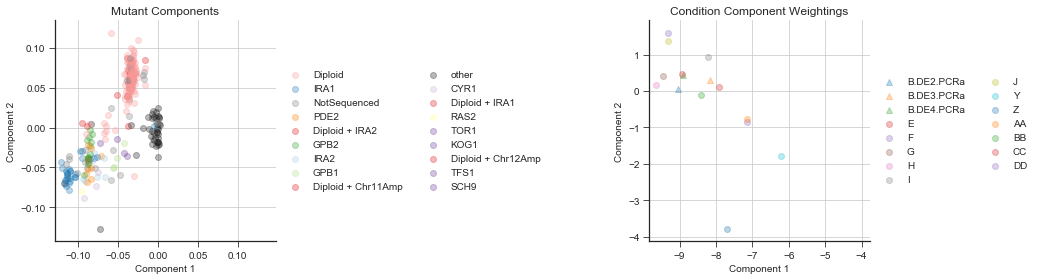

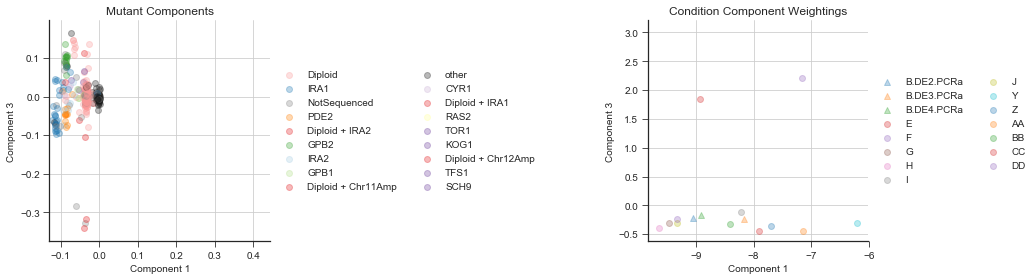

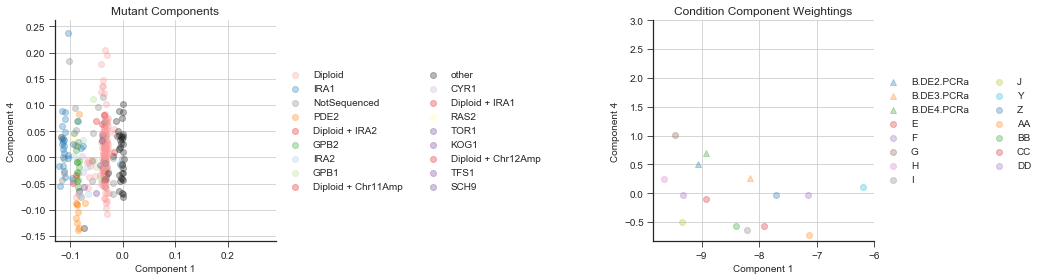

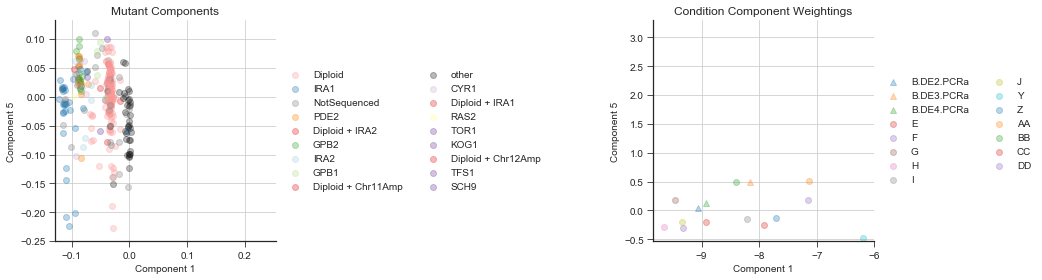

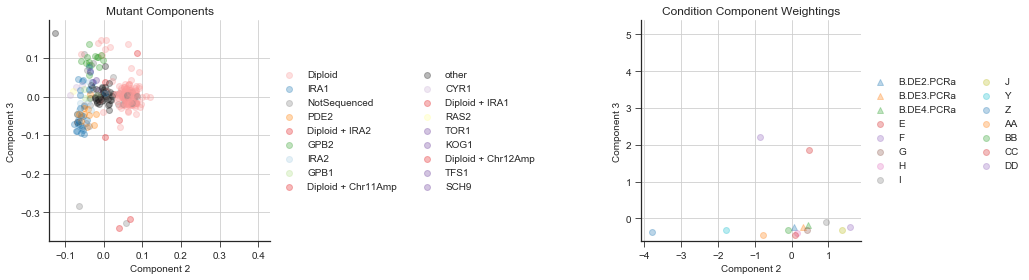

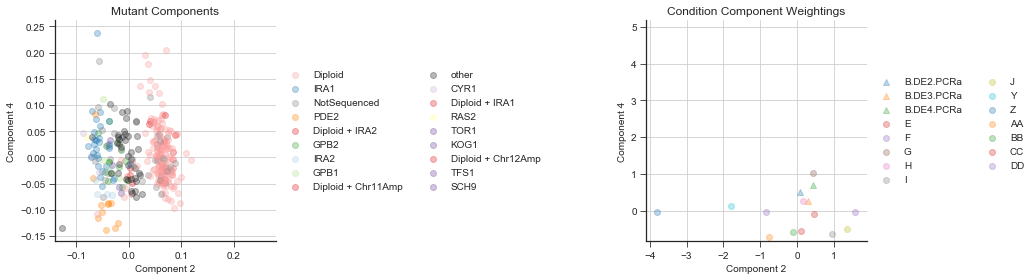

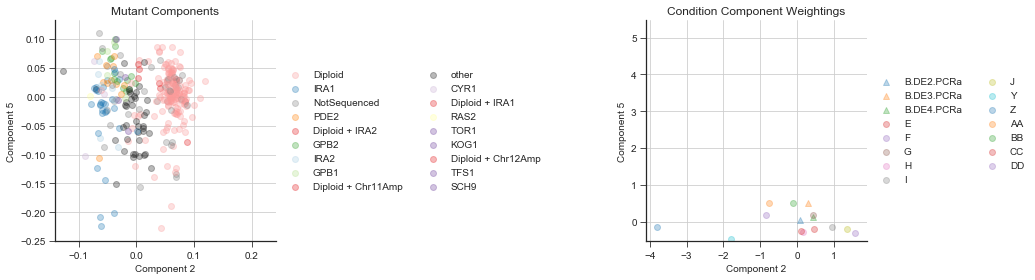

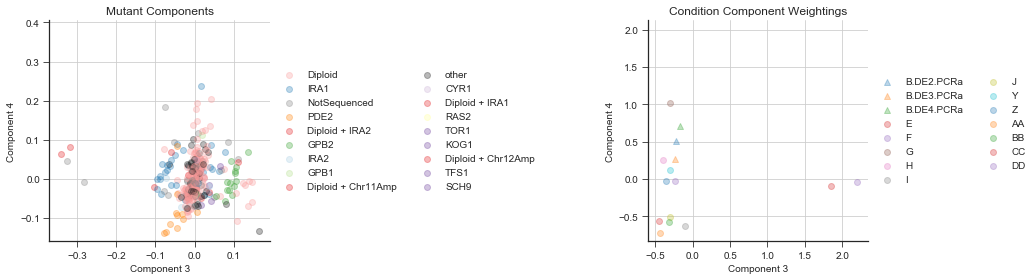

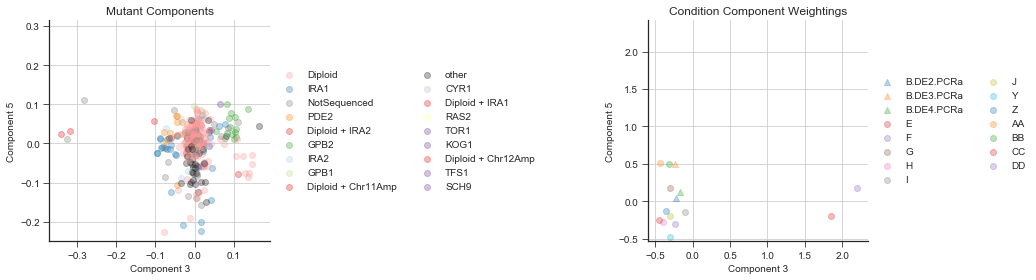

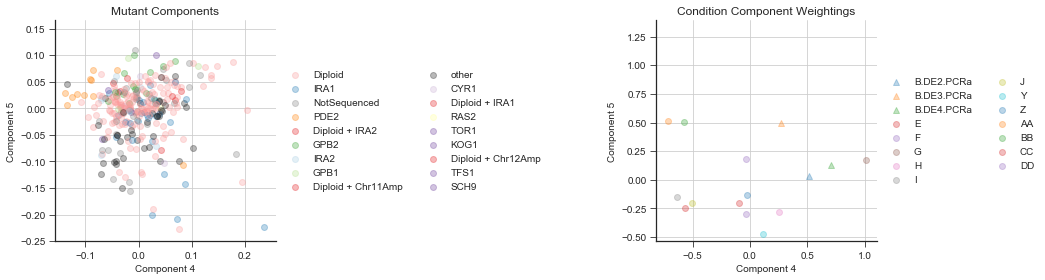

In [106]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna()

this_data = this_data.sort_values('barcode')

# fitness = this_data[[col+'_fitness' for col in all_conditions]].values
# error = this_data[[col+'_error' for col in all_conditions]].values

# fitness = this_data[[col+'_fitness' for col in all_reps]].values
# error = this_data[[col+'_error' for col in all_reps]].values

other_reps = [rep for reps in other_conditions.values() for rep in reps]

these_reps = technical_b + other_reps

fitness = this_data[[col+'_fitness' for col in these_reps]].values
error = this_data[[col+'_error' for col in these_reps]].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

fitness_cols = np.asarray([col for col in these_reps])

techb_rep_indices = np.where(np.isin(fitness_cols,technical_b))[0]
other_rep_indices = np.where(~np.isin(fitness_cols,technical_b))[0]

# fitness = this_data[[col+'_fitness' for col in these_reps]].values
# error = this_data[[col+'_error' for col in these_reps]].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

fitness_cols = np.asarray([col for col in these_reps])

# m3_rep_indices = np.where(np.isin(fitness_cols,m3_reps))[0]
# other_rep_indices = np.where(~np.isin(fitness_cols,m3_reps))[0]
techb_rep_indices = np.where(np.isin(fitness_cols,technical_b))[0]
other_rep_indices = np.where(~np.isin(fitness_cols,technical_b))[0]
techb_rep_indices = range(len(fitness_cols))


trainset = np.where(np.isin(this_data['barcode'].values,training_bcs))[0]
trainset = range(len(this_data['barcode'].values))

# fitness = fitness[np.repeat(trainset,len(other_rep_indices)),np.tile(other_rep_indices,len(trainset))].reshape(len(trainset),len(other_rep_indices))
# fitness = fitness[np.repeat(trainset,len(m3_rep_indices)),np.tile(m3_rep_indices,len(trainset))].reshape(len(trainset),len(m3_rep_indices))
fitness = fitness[np.repeat(trainset,len(techb_rep_indices)),np.tile(techb_rep_indices,len(trainset))].reshape(len(trainset),len(techb_rep_indices))




# this_data = this_data[this_data['barcode'].isin(training_bcs)]
this_data = this_data
# fitness_cols = [col+'_fitness' for col in all_reps if col not in m3_reps]
# fitness_cols = [col+'_fitness' for col in all_reps if col in m3_reps]


# fitness = [,other_rep_indices]


U, s, V = np.linalg.svd(fitness)

# color_set = sns.color_palette("Paired",18)
all_genes = np.unique(this_data['gene'].values)

mutant_colors = []
for gene in this_data['gene'].values:
    
#     index = np.where(all_genes==gene)[0][0]
#     mutant_colors.append(color_set[index])
    mutant_colors.append(mutant_colorset[gene])
    
condition_colors  = []

Vweighted = np.dot(np.diag(s),V)

for (x,y) in combinations(range(5),2):
    plt.figure(figsize=(16,4))
#     plt.suptitle(f'{x} )
    ax = plt.subplot(1,2,1)
    
    
#     tools.plot_mutant_components(ax,U,this_data,x,y,mutant_colorset)
    plt.title('Mutant Components')
    already_plotted = []
    for mut in range(fitness.shape[0]):
        plt.scatter(U[mut,x],U[mut,y],color=mutant_colors[mut],alpha=0.3,
                    label=f"{this_data['gene'].values[mut]}" if this_data['gene'].values[mut] not in already_plotted else '_nolegend_')
        already_plotted.append(this_data['gene'].values[mut])
    plt.xlabel(f'Component {x+1}')
    plt.ylabel(f'Component {y+1}')
    
    plt.axis('square')
    ax.set_aspect('equal','box')
    ax.grid(True, which='both')
    sns.despine(ax=ax, offset=0) # the important part here
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
    
    ax = plt.subplot(1,2,2)
    plt.title('Condition Component Weightings')
    already_plotted =[]
    for rep in range(fitness.shape[1]):
        this_rep = fitness_cols[techb_rep_indices[rep]]
        this_rep = fitness_cols[rep]
#         print(techb_rep_indices[rep])
        print(this_rep)
#         print(fitness_cols)
        
        if 'PCR' in this_rep:
#             rep_name = this_rep[0]
            condition_name = this_rep
#             condition_name = [name for name, reps in all_conditions.items() for rep in reps if rep == rep_name][0]
#             plt.scatter(Vweighted[x,rep],Vweighted[y,rep],alpha=0.3,
#                         color=condition_colorset[condition_name],marker='^',
#                         label=f"{condition_name}" if condition_name not in already_plotted else '_nolegend_')
            plt.scatter(Vweighted[x,rep],Vweighted[y,rep],alpha=0.3,
#                         color=sns.color_set(),
                        marker='^',
                        label=f"{condition_name}" if condition_name not in already_plotted else '_nolegend_')
        else:
#             print(this_rep)
            rep_name = this_rep.split('_fitness')[0]
            condition_name = this_rep
#             if rep_name in all_conditions.keys():
#                 condition_name = rep_name
#             else:
#                 condition_name = [name for name, reps in all_conditions.items() for rep in reps if rep == rep_name][0]
            plt.scatter(Vweighted[x,rep],Vweighted[y,rep],alpha=0.3,
#                         color=condition_colorset[condition_name],
                        label=f"{condition_name}" if condition_name not in already_plotted else '_nolegend_')
        already_plotted.append(condition_name)
            
    plt.xlabel(f'Component {x+1}')
    plt.ylabel(f'Component {y+1}')
    plt.axis('square')
    ax.set_aspect('equal','box')

    ax.grid(True, which='both')
    sns.despine(ax=ax, offset=0) # the important part here
    


    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
    plt.tight_layout()
    
    
    plt.savefig(f'supplemental_figures/space_plotted_TechBOthers+AllMutants_{x}_{y}.pdf',bbox_inches='tight')

In [291]:
fitness = fitness[np.where(np.isin(this_data['barcode'].values,training_bcs))[0],other_rep_indices]



IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (90,) (14,) 

In [292]:
fitness

array([[ 0.32833764,  0.35506261,  0.25497009, ...,  0.31515681,
         0.29061581,  0.40708344],
       [ 0.708218  ,  0.7788857 ,  0.67874916, ...,  1.05148513,
         0.95105941,  1.08586012],
       [ 0.06034412,  0.13312617,  0.05385894, ...,  0.33104384,
         0.30399187,  0.40770608],
       ...,
       [ 0.1323246 ,  0.23380552,  0.21096558, ...,  0.25651111,
         0.27286004,  0.47698582],
       [ 0.13547534,  0.2780962 ,  0.15185274, ...,  0.23862074,
         0.24859382,  0.44583736],
       [-0.02969287, -0.03594803, -0.09916509, ..., -0.01324524,
         0.00913029,  0.05649282]])